<a href="https://colab.research.google.com/github/Akshay594/fastai-projects/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As the name suggests, Neural Networks are loosely inpired from human brain nuerons. But we won't be covering any details about the brain analogies here. Rather, we will understand it with some math and coding.


# Perceptron

Perceptron was proposed by the Frank Rosenblatt in 1950s showing if an algorithm can imitate the human brain decision making capbalities (and we are still trying). He authored in his paper that we can consider an input as a neuron consists of binary numbers and those binary numbers can genrate a single binary number as an output, **if** and only **if** the output is satisfying a certain threshold.


$$y = \sum_i^n w_i * x_i$$

$$if y < threshold = `False`$$

$$else$$

    $$y = `True` $$
    
Where: 

$w$ is weights/parameters

$i$ is input neurons

$y$ predicted values

$threshold$ is a self chosen value

 
You may ask:

But Gopal, we can also write a program to do this task, why to bother  writing a a neural network? I am glad, you asked.

The very first reason for choosing a Neural Network over any program is they are **universal function approximators**, which infers to, no matter what model we are trying to build, or if it is too complex, neural networks always represents that function.

To put this in mathy words, we can assume to put any function into mathematical terms, and then we can use neural network to represent that function.

The second reson is, scalability and flexibility. We can stack easily layers in neural networks which will increase the complexity of the neural network.

It's enough of the theory for now let's code now.

### The basic architecture of neural networks

**Neural networks consist of the following components:**

<ul>
<li>An input layer, x</li>
<li>An arbitary amount of hidden layers</li>
<li>An output layer, $y$ </li>
<li>A set of weights and biases between each layer,$W$ and $b$</li>
<li>A choice of activation function for each hidden layer, $\sigma$</li>
</ul>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from zipfile import ZipFile

f = "/content/drive/My Drive/devanagari-character-set.zip"
with ZipFile(f, "r") as zip:
  zip.extractall()
  print("Done")

Done


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable

In [0]:
def plot_images(df, n, label):
    for i in range(n**2):
        random_value = np.random.randint(len(df[label]))
        plt.subplot(n, n, i+1)
        X = df.iloc[random_value, :-1].values.astype("int").reshape(32, 32)
        plt.imshow(X, cmap="binary")
        plt.title(str(df[label][random_value]), color="green", fontsize=28)
        plt.axis("off")
        plt.subplots_adjust(left=1, right=4.5, bottom=.5, top=2.5)
    plt.figure(figsize=(10, 10))
    plt.show()

In [0]:
df = pd.read_csv("data.csv")

In [4]:
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,pixel_0010,pixel_0011,pixel_0012,pixel_0013,pixel_0014,pixel_0015,pixel_0016,pixel_0017,pixel_0018,pixel_0019,pixel_0020,pixel_0021,pixel_0022,pixel_0023,pixel_0024,pixel_0025,pixel_0026,pixel_0027,pixel_0028,pixel_0029,pixel_0030,pixel_0031,pixel_0032,pixel_0033,pixel_0034,pixel_0035,pixel_0036,pixel_0037,pixel_0038,pixel_0039,...,pixel_0985,pixel_0986,pixel_0987,pixel_0988,pixel_0989,pixel_0990,pixel_0991,pixel_0992,pixel_0993,pixel_0994,pixel_0995,pixel_0996,pixel_0997,pixel_0998,pixel_0999,pixel_1000,pixel_1001,pixel_1002,pixel_1003,pixel_1004,pixel_1005,pixel_1006,pixel_1007,pixel_1008,pixel_1009,pixel_1010,pixel_1011,pixel_1012,pixel_1013,pixel_1014,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka


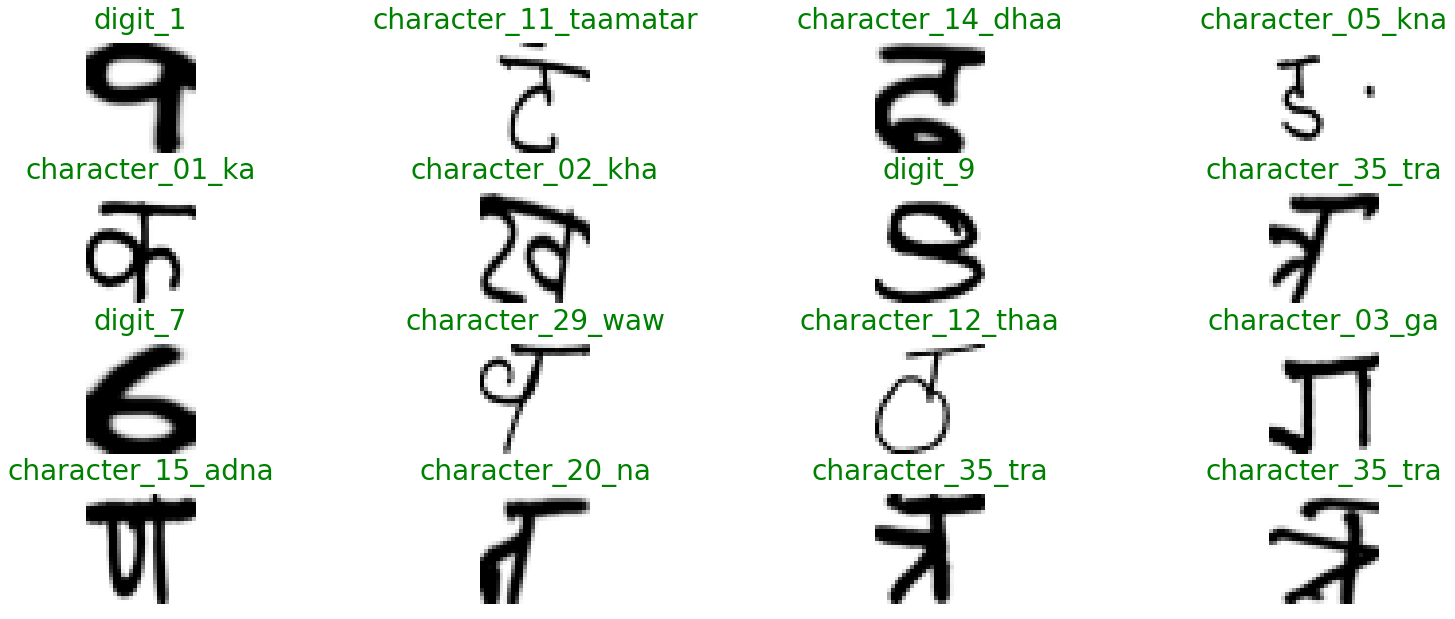

<Figure size 720x720 with 0 Axes>

In [5]:
plot_images(df, 4, "character")

In [0]:
train = pd.read_csv("data.csv")

targets_numpy = train.character.values
features_numpy = train.iloc[:, :-1].values/255.0

In [0]:
le = LabelEncoder()
targets_encoded = le.fit_transform(targets_numpy)
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_encoded, test_size=0.2, random_state=123)

In [0]:
def data_loader(features,labels, batch_size):
  feature = torch.from_numpy(features)
  target = torch.from_numpy(labels)

  data = torch.utils.data.TensorDataset(feature, target)

  dataloaded = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = False)

  return dataloaded

In [0]:
train_loader = data_loader(features_train, targets_train, 128)
test_loader = data_loader(features_test, targets_test, 128)

In [0]:
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)         
        self.fc2 = nn.Linear(512, 256)        
        self.fc3 = nn.Linear(256, 128)        
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 46)

        self.dropout = nn.Dropout(p=0.2)
        self.log_softmax = F.log_softmax
    
    def forward(self, x):
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x = self.dropout(F.relu(self.fc3(x)))
      x = self.dropout(F.relu(self.fc4(x)))

      x = self.log_softmax(self.fc5(x), dim=1)
      return x

In [0]:
model = ANNModel()
# Define our loss function
criterion = nn.CrossEntropyLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

In [12]:
for e in range(epochs):
  running_loss = 0
  for images, labels in train_loader:
    steps += 1
    optimizer.zero_grad()
    prediction = model(images.float())
    loss = criterion(prediction, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0

      with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
          prediction_test = model(images.float())
          test_loss += criterion(prediction_test, labels)

          prediction_test = torch.exp(prediction_test)

          top_k, top_class = prediction_test.topk(1, dim=1)
          equals = (top_class == labels.view(*top_class.shape))
          accuracy += torch.mean(equals.type(torch.FloatTensor))

      model.train()
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(test_loss/len(test_loader))

      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_losses[-1]),
            "Test Loss: {:.3f}.. ".format(test_losses[-1]),
            "Test Accuracy: {:.3f}.. ".format(accuracy/len(test_loader)))


Epoch: 1/25..  Training Loss: 0.315..  Test Loss: 3.114..  Test Accuracy: 0.170.. 
Epoch: 1/25..  Training Loss: 0.553..  Test Loss: 2.163..  Test Accuracy: 0.387.. 
Epoch: 1/25..  Training Loss: 0.741..  Test Loss: 1.720..  Test Accuracy: 0.506.. 
Epoch: 1/25..  Training Loss: 0.899..  Test Loss: 1.448..  Test Accuracy: 0.594.. 
Epoch: 1/25..  Training Loss: 1.038..  Test Loss: 1.254..  Test Accuracy: 0.651.. 
Epoch: 1/25..  Training Loss: 1.163..  Test Loss: 1.115..  Test Accuracy: 0.682.. 
Epoch: 1/25..  Training Loss: 1.278..  Test Loss: 1.013..  Test Accuracy: 0.715.. 
Epoch: 1/25..  Training Loss: 1.386..  Test Loss: 0.910..  Test Accuracy: 0.739.. 
Epoch: 1/25..  Training Loss: 1.486..  Test Loss: 0.849..  Test Accuracy: 0.758.. 
Epoch: 1/25..  Training Loss: 1.578..  Test Loss: 0.799..  Test Accuracy: 0.769.. 
Epoch: 1/25..  Training Loss: 1.668..  Test Loss: 0.748..  Test Accuracy: 0.786.. 
Epoch: 2/25..  Training Loss: 0.041..  Test Loss: 0.686..  Test Accuracy: 0.804.. 
Epoc

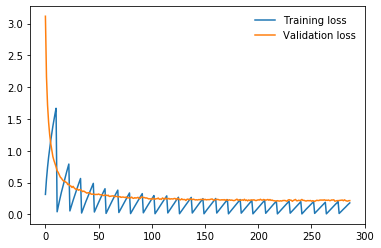

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
classes = list(le.classes_)

def make_predictions(data, number):
  images, labels = next(iter(data))
  img = images[number].view(1, 32*32)
  with torch.no_grad():
    logpreds = model(img.float())
  pred = torch.exp(logpreds)

  pred = pred.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), ncols=2)
  ax1.imshow(img.reshape(32, 32), cmap="binary")
  ax1.axis("off")
  ax2.barh(np.arange(46), pred)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(46))
  ax2.set_yticklabels(classes)
  ax2.set_title('Highest Probability Of a class')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

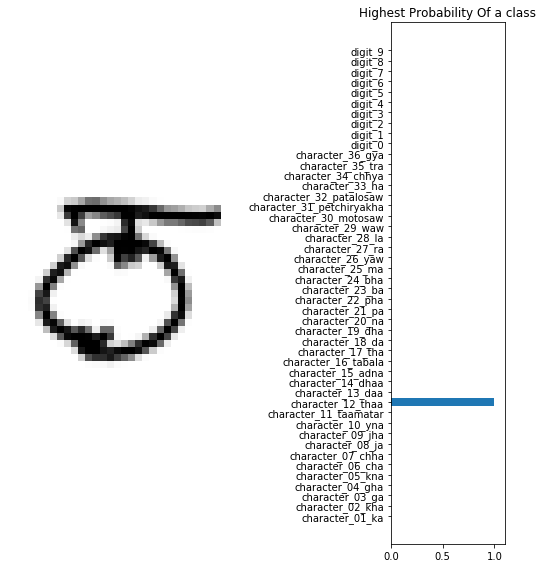

In [21]:
make_predictions(test_loader, 44)